# EE 344 - Assignment 2: Power Plant Regression



---

## Assignment Overview

This assignment investigates:
- **Outlier detection and removal** using Cook's Distance
- **Model performance comparison** before and after outlier removal
- **Coefficient reliability analysis** (statistical significance)
- **Feature importance** analysis
- **Regularization paths** for Ridge and Lasso regression

**Dataset:** `usina_with_outliers.csv` (Power Plant dataset with artificial outliers)

**Variables:**
- Independent Variables (IVs): AT (Ambient Temperature), V (Exhaust Vacuum), AP (Ambient Pressure), RH (Relative Humidity)
- Dependent Variable (DV): PE (Power Output)

**Train/Test Split:** 70% / 30% with fixed random state

---

## Setup and Imports

In [1]:
# === Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.precision", 4)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Random seed for reproducibility
RANDOM_STATE = 42

## Load Data

In [2]:
# Load the dataset with outliers
df_with_outliers = pd.read_csv('usina_with_outliers.csv')

print(f"Dataset shape: {df_with_outliers.shape}")
print(f"\nColumn names: {list(df_with_outliers.columns)}")
print(f"\nFirst few rows:")
display(df_with_outliers.head())

print(f"\nBasic statistics:")
display(df_with_outliers.describe())

print(f"\nMissing values:")
print(df_with_outliers.isnull().sum())

Dataset shape: (9568, 5)

Column names: ['AT', 'V', 'AP', 'RH', 'PE']

First few rows:


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90



Basic statistics:


,AT,V,AP,RH,PE
count,9568.0000,9568.0000,9568.0000,9568.0000,9568.0000
mean,19.6185,54.2500,1013.2889,73.3090,454.4078
std,8.2564,13.9937,6.6366,16.0945,18.7600
min,-39.1748,-38.3974,959.6073,-53.0916,327.5280
25%,13.4800,41.6700,1009.0775,63.2275,439.7300
50%,20.3200,52.0800,1012.9500,74.9550,451.6200
75%,25.7325,66.5400,1017.3200,84.8825,468.5300
max,77.3448,155.1174,1064.7727,187.6916,590.0920



Missing values:
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64


---
# Q1: Outlier Detection and Removal using Cook's Distance (25 points)

## Q1.1 — Model Choice and Justification (10 points)

### Justification for Model and Library Choice

**Model: Linear Regression**

- Cook's distance is defined for **OLS**: it measures how much the fitted coefficients change when one observation is removed. Using it with Linear Regression is the standard setup.
- Ridge/Lasso add regularization (λ), which can **mask** outlier influence and would require choosing λ; for outlier detection we want a direct OLS fit with no extra tuning.

**Library: Statsmodels OLS**

- **Built-in Cook's distance:** Statsmodels `OLSInfluence` exposes `.cooks_distance` directly—no manual formula or custom code.
- **Diagnostics-oriented:** Statsmodels is built for regression diagnostics; scikit-learn would need regression + custom Cook's distance implementation.

## Q1.2 — Identify Outliers, Remove Them, and Export Clean CSV (15 points)

In [3]:
# Prepare data for Cook's Distance calculation
X = df_with_outliers[['AT', 'V', 'AP', 'RH']].values
y = df_with_outliers['PE'].values

# Add constant term (intercept) for Statsmodels OLS
X_with_const = sm.add_constant(X)

# Fit OLS model
ols_model = sm.OLS(y, X_with_const).fit()

# Get influence measures including Cook's Distance
influence = OLSInfluence(ols_model)
cooks_d, pvals = influence.cooks_distance

In [4]:
# Identify outliers using the standard 4/n threshold
n = len(cooks_d)
threshold = 4 / n

print(f"\nOutlier Detection:")
print(f"Sample size (n): {n}")
print(f"Threshold (4/n): {threshold:.6f}")

# Find outliers
outlier_mask = cooks_d > threshold
num_outliers = outlier_mask.sum()

print(f"\nNumber of outliers detected: {num_outliers}")
print(f"Percentage of data identified as outliers: {100 * num_outliers / n:.2f}%")


Outlier Detection:
Sample size (n): 9568
Threshold (4/n): 0.000418

Number of outliers detected: 120
Percentage of data identified as outliers: 1.25%


In [5]:
# Remove outliers and create clean dataset
df_clean = df_with_outliers[~outlier_mask].copy()

print(f"\nDataset Comparison:")
print(f"Original dataset size: {len(df_with_outliers)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Removed: {len(df_with_outliers) - len(df_clean)} observations")

# Reset index for clean dataset
df_clean = df_clean.reset_index(drop=True)

print(f"\nClean dataset statistics:")
display(df_clean.describe())


Dataset Comparison:
Original dataset size: 9568
Clean dataset size: 9448
Removed: 120 observations

Clean dataset statistics:


,AT,V,AP,RH,PE
count,9448.0000,9448.0000,9448.0000,9448.0000,9448.0000
mean,19.6888,54.3452,1013.2675,73.3294,454.2997
std,7.4476,12.7410,5.9291,14.7609,17.0424
min,1.8100,25.3600,975.1773,-6.3016,334.7980
25%,13.5500,41.7400,1009.1100,63.3200,439.7575
50%,20.3650,52.3000,1012.9500,74.9550,451.4800
75%,25.7200,66.5400,1017.2600,84.8200,468.3525
max,75.8248,148.0474,1033.3000,178.7416,495.7600


In [6]:
# Export clean dataset to CSV
df_clean.to_csv('usina.csv', index=False)
print(f"  Shape: {df_clean.shape}")
print(f"  Columns: {list(df_clean.columns)}")

# Verify the export
df_verify = pd.read_csv('usina.csv')

  Shape: (9448, 5)
  Columns: ['AT', 'V', 'AP', 'RH', 'PE']


---
# Q2: Train/Test Evaluation Before vs After Outlier Removal (20 points)

**Important:** For Q2, we do NOT scale features or the target variable.

## Helper Functions for Model Evaluation

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a trained model on both train and test sets.
    Returns a dictionary with all metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Train_MSE': mean_squared_error(y_train, y_train_pred),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred),
        'Test_MSE': mean_squared_error(y_test, y_test_pred),
        'Test_R2': r2_score(y_test, y_test_pred)
    }
    
    return metrics

def train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, lambda_val=None):
    """
    Train a model and return its evaluation metrics.
    """
    # Train the model
    model.fit(X_train, y_train.ravel())
    
    # Evaluate
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    # Add model info
    result = {'Model': model_name}
    if lambda_val is not None:
        result['Lambda'] = lambda_val
    result.update(metrics)
    
    return result

## Q2.1 — Performance on Dataset WITH Outliers

In [8]:
# Prepare data with outliers (NO SCALING as per Q2 requirement)
X_with = df_with_outliers[['AT', 'V', 'AP', 'RH']].values
y_with = df_with_outliers['PE'].values

# Train/test split (70/30)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with, y_with, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Dataset WITH outliers:")
print(f"  Training set size: {X_train_with.shape[0]}")
print(f"  Test set size: {X_test_with.shape[0]}")

Dataset WITH outliers:
  Training set size: 6697
  Test set size: 2871


In [9]:
# Lambda values for Ridge and Lasso
lambda_values = [0.01, 0.1, 1, 10, 100]

# Storage for results
results_with_outliers = []

# 1. Linear Regression
lr = LinearRegression()
result = train_and_evaluate('Linear Regression', lr, X_train_with, y_train_with, X_test_with, y_test_with)
results_with_outliers.append(result)
print(" Linear Regression trained")

# 2. Ridge Regression
for lam in lambda_values:
    ridge = Ridge(alpha=lam, random_state=RANDOM_STATE)
    result = train_and_evaluate(f'Ridge', ridge, X_train_with, y_train_with, X_test_with, y_test_with, lam)
    results_with_outliers.append(result)
print(" Ridge Regression trained for all λ values")

# 3. Lasso Regression
for lam in lambda_values:
    lasso = Lasso(alpha=lam, random_state=RANDOM_STATE, max_iter=10000)
    result = train_and_evaluate(f'Lasso', lasso, X_train_with, y_train_with, X_test_with, y_test_with, lam)
    results_with_outliers.append(result)
print(" Lasso Regression trained for all λ values")

# Convert to DataFrame
df_results_with = pd.DataFrame(results_with_outliers)

print(f"\n{'='*80}")
print(f"RESULTS: Dataset WITH Outliers")
print(f"{'='*80}")
display(df_results_with)

 Linear Regression trained
 Ridge Regression trained for all λ values
 Lasso Regression trained for all λ values

RESULTS: Dataset WITH Outliers


,Model,Train_MAE,Train_MSE,Train_R2,Test_MAE,Test_MSE,Test_R2,Lambda
0,Linear Regression,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,NaN
1,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,0.01
2,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,0.10
3,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,1.00
4,Ridge,5.1987,123.3842,0.6502,5.0525,125.1137,0.6426,10.00
5,Ridge,5.1993,123.3842,0.6502,5.0530,125.1165,0.6426,100.00
6,Lasso,5.1989,123.3842,0.6502,5.0526,125.1153,0.6426,0.01
7,Lasso,5.2017,123.3846,0.6502,5.0553,125.1345,0.6425,0.10
8,Lasso,5.2295,123.4212,0.6501,5.0831,125.3384,0.6419,1.00
9,Lasso,5.5404,126.1415,0.6424,5.4088,128.9021,0.6318,10.00


## Q2.2 — Performance on Dataset WITHOUT Outliers (Clean)

In [10]:
# Prepare clean data (NO SCALING as per Q2 requirement)
X_clean = df_clean[['AT', 'V', 'AP', 'RH']].values
y_clean = df_clean['PE'].values

# Train/test split (70/30)
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Dataset WITHOUT outliers (clean):")
print(f"  Training set size: {X_train_clean.shape[0]}")
print(f"  Test set size: {X_test_clean.shape[0]}")

Dataset WITHOUT outliers (clean):
  Training set size: 6613
  Test set size: 2835


In [11]:
# Storage for results
results_without_outliers = []

# 1. Linear Regression
lr = LinearRegression()
result = train_and_evaluate('Linear Regression', lr, X_train_clean, y_train_clean, X_test_clean, y_test_clean)
results_without_outliers.append(result)
print(" Linear Regression trained")

# 2. Ridge Regression
for lam in lambda_values:
    ridge = Ridge(alpha=lam, random_state=RANDOM_STATE)
    result = train_and_evaluate(f'Ridge', ridge, X_train_clean, y_train_clean, X_test_clean, y_test_clean, lam)
    results_without_outliers.append(result)
print(" Ridge Regression trained for all λ values")

# 3. Lasso Regression
for lam in lambda_values:
    lasso = Lasso(alpha=lam, random_state=RANDOM_STATE, max_iter=10000)
    result = train_and_evaluate(f'Lasso', lasso, X_train_clean, y_train_clean, X_test_clean, y_test_clean, lam)
    results_without_outliers.append(result)
print(" Lasso Regression trained for all λ values")

# Convert to DataFrame
df_results_without = pd.DataFrame(results_without_outliers)

print(f"\n{'='*80}")
print(f"RESULTS: Dataset WITHOUT Outliers (Clean)")
print(f"{'='*80}")
display(df_results_without)

 Linear Regression trained
 Ridge Regression trained for all λ values
 Lasso Regression trained for all λ values

RESULTS: Dataset WITHOUT Outliers (Clean)


,Model,Train_MAE,Train_MSE,Train_R2,Test_MAE,Test_MSE,Test_R2,Lambda
0,Linear Regression,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,NaN
1,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,0.01
2,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,0.10
3,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,1.00
4,Ridge,3.5964,19.8647,0.9314,3.6248,20.3965,0.9303,10.00
5,Ridge,3.5967,19.8648,0.9314,3.6249,20.3946,0.9303,100.00
6,Lasso,3.5964,19.8647,0.9314,3.6248,20.3967,0.9303,0.01
7,Lasso,3.5969,19.8653,0.9314,3.6249,20.3926,0.9303,0.10
8,Lasso,3.6055,19.9299,0.9311,3.6312,20.4148,0.9302,1.00
9,Lasso,4.0866,25.6857,0.9113,4.1205,26.1573,0.9106,10.00


## Q2.3 & Q2.4 — Combined Results Table and Discussion

In [12]:
# Create side-by-side comparison
print(f"\n{'='*100}")
print(f"COMPARISON: WITH OUTLIERS vs WITHOUT OUTLIERS")
print(f"{'='*100}\n")

print("WITH OUTLIERS:")
display(df_results_with)

print("\nWITHOUT OUTLIERS (Clean):")
display(df_results_without)


COMPARISON: WITH OUTLIERS vs WITHOUT OUTLIERS

WITH OUTLIERS:


,Model,Train_MAE,Train_MSE,Train_R2,Test_MAE,Test_MSE,Test_R2,Lambda
0,Linear Regression,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,NaN
1,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,0.01
2,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,0.10
3,Ridge,5.1987,123.3842,0.6502,5.0525,125.1134,0.6426,1.00
4,Ridge,5.1987,123.3842,0.6502,5.0525,125.1137,0.6426,10.00
5,Ridge,5.1993,123.3842,0.6502,5.0530,125.1165,0.6426,100.00
6,Lasso,5.1989,123.3842,0.6502,5.0526,125.1153,0.6426,0.01
7,Lasso,5.2017,123.3846,0.6502,5.0553,125.1345,0.6425,0.10
8,Lasso,5.2295,123.4212,0.6501,5.0831,125.3384,0.6419,1.00
9,Lasso,5.5404,126.1415,0.6424,5.4088,128.9021,0.6318,10.00



WITHOUT OUTLIERS (Clean):


,Model,Train_MAE,Train_MSE,Train_R2,Test_MAE,Test_MSE,Test_R2,Lambda
0,Linear Regression,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,NaN
1,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,0.01
2,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,0.10
3,Ridge,3.5964,19.8647,0.9314,3.6248,20.3968,0.9303,1.00
4,Ridge,3.5964,19.8647,0.9314,3.6248,20.3965,0.9303,10.00
5,Ridge,3.5967,19.8648,0.9314,3.6249,20.3946,0.9303,100.00
6,Lasso,3.5964,19.8647,0.9314,3.6248,20.3967,0.9303,0.01
7,Lasso,3.5969,19.8653,0.9314,3.6249,20.3926,0.9303,0.10
8,Lasso,3.6055,19.9299,0.9311,3.6312,20.4148,0.9302,1.00
9,Lasso,4.0866,25.6857,0.9113,4.1205,26.1573,0.9106,10.00


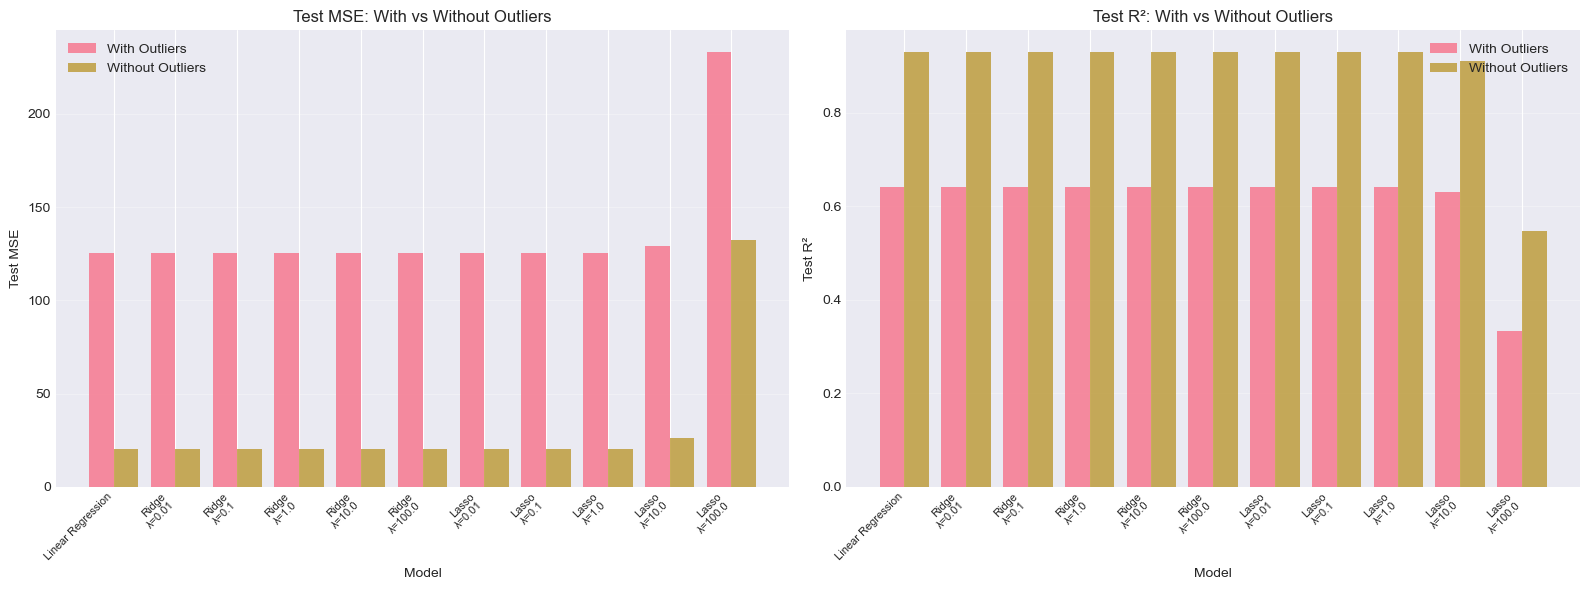

In [13]:
# Visualization: Compare Test MSE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Test MSE comparison
models = df_results_with['Model'].values
x_pos = np.arange(len(models))

axes[0].bar(x_pos - 0.2, df_results_with['Test_MSE'], width=0.4, label='With Outliers', alpha=0.8)
axes[0].bar(x_pos + 0.2, df_results_without['Test_MSE'], width=0.4, label='Without Outliers', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Test MSE')
axes[0].set_title('Test MSE: With vs Without Outliers')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f"{m}\nλ={l}" if pd.notna(l) else m 
                         for m, l in zip(df_results_with['Model'], df_results_with['Lambda'])], 
                        rotation=45, ha='right', fontsize=8)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Test R² comparison
axes[1].bar(x_pos - 0.2, df_results_with['Test_R2'], width=0.4, label='With Outliers', alpha=0.8)
axes[1].bar(x_pos + 0.2, df_results_without['Test_R2'], width=0.4, label='Without Outliers', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R²: With vs Without Outliers')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f"{m}\nλ={l}" if pd.notna(l) else m 
                         for m, l in zip(df_results_with['Model'], df_results_with['Lambda'])], 
                        rotation=45, ha='right', fontsize=8)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Discussion: Q2 Results

#### 1. Do outliers change train error? Test error?

Yes, outliers significantly affect both training and test errors. For Linear Regression, the dataset with outliers shows Train_MAE=5.1987 and Train_MSE=123.3842, while the dataset without outliers shows Train_MAE=3.5964 and Train_MSE=19.8647. This represents an increase of approximately 44% in MAE and 521% in MSE when outliers are present. Similarly, for test errors, the dataset with outliers shows Test_MAE=5.0525 and Test_MSE=125.1134, compared to Test_MAE=3.6248 and Test_MSE=20.3968 without outliers, representing increases of approximately 39% in MAE and 513% in MSE. The outliers substantially degrade model performance on both training and test sets, with MSE being more severely impacted than MAE due to its sensitivity to large errors.

#### 2. Which dataset (with outliers vs without outliers) shows better generalization?

The dataset without outliers demonstrates significantly better generalization. The test R² for the clean dataset is 0.9303, compared to 0.6426 for the dataset with outliers, indicating that the model explains approximately 93% of the variance in the clean data versus only 64% in the data with outliers. Additionally, the test MSE is much lower for the clean dataset (20.3968) compared to the dataset with outliers (125.1134), representing a reduction of approximately 84%. The close match between training and test performance (Train_R2=0.9314 vs Test_R2=0.9303) for the clean dataset also suggests better generalization, as there is minimal overfitting. In contrast, the dataset with outliers shows a larger gap between training and test performance, indicating potential overfitting issues.

#### 3. Do Ridge/Lasso appear to help relative to standard linear regression?

For this dataset, Ridge and Lasso regression do not provide significant improvements over standard linear regression. For small lambda values (0.01, 0.1, 1), both Ridge and Lasso produce results nearly identical to linear regression, with differences in metrics being negligible (e.g., Test_MSE differences of less than 0.1). For larger lambda values (10, 100), Lasso regression actually performs worse, especially with λ=100 where Test_R2 drops to 0.3342 (with outliers) and 0.5484 (without outliers), compared to 0.6426 and 0.9303 for linear regression respectively. Ridge regression maintains performance close to linear regression even at high lambda values. This suggests that the dataset does not suffer from significant overfitting or multicollinearity issues that would benefit from regularization, and the standard linear regression model is already well-suited for this problem.



---
# Q3: Reliability of Coefficients (20 points)

**Dataset:** Using `usina.csv` (outlier-removed dataset)

## Q3.1 — Method Choice and Scaling Decision (10 points)

### Discussion: Justification for Method and Scaling Choice

#### 1. Why choose this model? (Linear vs Ridge vs Lasso)

**Linear Regression.** Coefficient reliability is assessed by **t-statistics** and **p-values**. These require **unbiased** OLS estimates. Ridge and Lasso add regularization (shrink coefficients), so their estimates are **biased** and t-tests/p-values are not valid for inference. For reliability we need unbiased estimates → Linear Regression.

#### 2. Why choose this library? (Statsmodels vs scikit-learn)

**Statsmodels OLS.** It reports **standard errors, t-statistics, p-values, and confidence intervals** directly in `.summary()`. sklearn `LinearRegression` does not; you would have to compute them manually. For coefficient reliability we need these statistics → Statsmodels.

---

#### 3. Should we scale IVs and/or DV for this coefficient reliability task?

**No.** Scaling is not required for coefficient reliability.

#### 4. Is scaling helpful or harmful for the metric you want to measure?

**Neither—irrelevant.** The metric is the **t-statistic** $t = \hat{\beta}_j / SE(\hat{\beta}_j)$. If we scale a feature $X_j$ (e.g. by $\sigma_j$), both $\hat{\beta}_j$ and $SE(\hat{\beta}_j)$ scale the same way, so $t$ and the p-value **do not change**. Reliability ranking (most/least reliable by |t| or p-value) is **scale-invariant**. We use no scaling to keep coefficients in original units and follow standard practice.

---



## Q3.2 — Implementation and Results (10 points)

In [25]:
# Use clean dataset (already loaded as df_clean)
# Prepare data WITHOUT scaling (as justified above)
X_q3 = df_clean[['AT', 'V', 'AP', 'RH']].values
y_q3 = df_clean['PE'].values

# Add constant for intercept
X_q3_with_const = sm.add_constant(X_q3)

# Fit OLS model on the entire clean dataset
# (We use full dataset for coefficient reliability analysis to maximize statistical power)
ols_q3 = sm.OLS(y_q3, X_q3_with_const).fit()

# Display full summary
print("\n" + "="*80)
print("OLS REGRESSION SUMMARY - Coefficient Reliability Analysis")
print("="*80)
print(ols_q3.summary())


OLS REGRESSION SUMMARY - Coefficient Reliability Analysis
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Wed, 28 Jan 2026   Prob (F-statistic):               0.00
Time:                        20:08:18   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [26]:
# Extract coefficient statistics
feature_names = ['AT', 'V', 'AP', 'RH']

# Get coefficient values, standard errors, t-statistics, and p-values
coef_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ols_q3.params[1:],  # Skip intercept
    'Std_Error': ols_q3.bse[1:],
    't_statistic': ols_q3.tvalues[1:],
    'p_value': ols_q3.pvalues[1:],
    '|t_statistic|': np.abs(ols_q3.tvalues[1:])
})

# Sort by absolute t-statistic (reliability measure)
coef_table_sorted = coef_table.sort_values('|t_statistic|', ascending=False)

print("\n" + "="*80)
print("COEFFICIENT RELIABILITY RANKING (by |t-statistic|)")
print("="*80)
display(coef_table_sorted)

# Identify most and least reliable
most_reliable = coef_table_sorted.iloc[0]
least_reliable = coef_table_sorted.iloc[-1]

print("\n" + "="*80)
print("RESULTS: Most and Least Reliable Coefficients")
print("="*80)

print("\n MOST RELIABLE COEFFICIENT:")
print(f"   Feature: {most_reliable['Feature']}")
print(f"   Coefficient: {most_reliable['Coefficient']:.6f}")
print(f"   t-statistic: {most_reliable['t_statistic']:.4f}")
print(f"   |t-statistic|: {most_reliable['|t_statistic|']:.4f}")
print(f"   p-value: {most_reliable['p_value']:.2e}")
print(f"   ➜ This coefficient is highly statistically significant (p < 0.05)")

print("\n  LEAST RELIABLE COEFFICIENT:")
print(f"   Feature: {least_reliable['Feature']}")
print(f"   Coefficient: {least_reliable['Coefficient']:.6f}")
print(f"   t-statistic: {least_reliable['t_statistic']:.4f}")
print(f"   |t-statistic|: {least_reliable['|t_statistic|']:.4f}")
print(f"   p-value: {least_reliable['p_value']:.2e}")
if least_reliable['p_value'] > 0.05:
    print(f"   ➜ This coefficient is NOT statistically significant at the 0.05 level")
else:
    print(f"   ➜ This coefficient is still statistically significant, but less reliable than others")


COEFFICIENT RELIABILITY RANKING (by |t-statistic|)


,Feature,Coefficient,Std_Error,t_statistic,p_value,|t_statistic|
0,AT,-1.9546,0.0151,-129.1130,0.0000e+00,129.1130
3,RH,-0.1489,0.0040,-36.8973,1.5780e-278,36.8973
1,V,-0.2379,0.0072,-33.0565,7.5270e-227,33.0565
2,AP,0.0746,0.0095,7.8945,3.2386e-15,7.8945



RESULTS: Most and Least Reliable Coefficients

 MOST RELIABLE COEFFICIENT:
   Feature: AT
   Coefficient: -1.954640
   t-statistic: -129.1130
   |t-statistic|: 129.1130
   p-value: 0.00e+00
   ➜ This coefficient is highly statistically significant (p < 0.05)

  LEAST RELIABLE COEFFICIENT:
   Feature: AP
   Coefficient: 0.074638
   t-statistic: 7.8945
   |t-statistic|: 7.8945
   p-value: 3.24e-15
   ➜ This coefficient is still statistically significant, but less reliable than others


### Discussion: Q3 Results

#### Clearly report your reasoning and show the outputs you used to make the decision.

**Reasoning:** Reliability is measured by **|t-statistic|** from the OLS fit ($t = \hat{\beta}_j / SE(\hat{\beta}_j)$): larger |t| means the coefficient is more precisely estimated (more reliable). The **outputs used** are: (1) the **OLS summary** printed above (coefficients, std err, t, P>|t|), and (2) the **COEFFICIENT RELIABILITY RANKING** table above, which sorts features by |t-statistic|.

**Decision (from the ranking table above):**

- **Most reliable coefficient:** **AT** — |t| = 129.11 (largest), p ≈ 0.  
- **Least reliable coefficient:** **AP** — |t| = 7.89 (smallest), p = 3.24e-15 (still significant).

**Ranking (by |t|):** AT (129.11) > RH (36.90) > V (33.06) > AP (7.89).


---
# Q4: Most Important vs Least Important Features (20 points)

**Dataset:** Using `usina.csv` (outlier-removed dataset)

## Q4.1 — Method Choice and Scaling Decision (10 points)

### Justification for Method and Scaling Choice

**1. Model: Lasso Regression**

Feature importance here is based on **coefficient magnitude** (larger |β| = more important). Lasso shrinks weak effects toward zero, so ranking by |coefficient| on scaled features gives a clear importance order. The assignment requires trying several λ and selecting the best λ if we use Ridge or Lasso; Lasso satisfies this and yields interpretable |coef| for ranking.

**2. Library: Scikit-learn**

Scikit-learn provides **Lasso** and **LassoCV** (λ selection by cross-validation) and integrates with **StandardScaler**; Lasso is scale-sensitive, so this pipeline is needed. Coefficients via `.coef_`, chosen λ via `alpha_`. Statsmodels does not offer LassoCV in the same way → Scikit-learn.

**3. Scale IVs and/or DV?**

**Yes, scale IVs only** (do not scale DV).

**4. Justify: Why scaling affects coefficient magnitude and importance**

- **Unscaled IVs:** Features have different units (e.g. °C vs hPa), so **raw coefficient magnitudes are not comparable**—a small |β| for one feature can mean a larger effect than a large |β| for another.
- **Scale IVs (e.g. StandardScaler):** All IVs are on the same scale (e.g. mean 0, std 1). Each coefficient then means "change in DV per one standard deviation of that IV," so **|coefficient| is directly comparable** across features: larger |β| = more important.
- **Do not scale DV:** Keeps coefficients in original DV units (e.g. MW per 1 SD of feature), so interpretability is preserved; importance ranking is driven by scaling IVs.

**Summary:** Model: Lasso (Scikit-learn, best λ selected). Scaling: IVs only (StandardScaler). Metric: |coefficient| on scaled IVs. Most important: largest |β|; least important: smallest |β|.

## Q4.2 — Implementation and Results (10 points)

In [16]:
# Prepare data: Scale IVs only, NOT DV
X_q4 = df_clean[['AT', 'V', 'AP', 'RH']].values
y_q4 = df_clean['PE'].values

# Standardize IVs
scaler_X = StandardScaler()
X_q4_scaled = scaler_X.fit_transform(X_q4)

# Keep DV in original units (no scaling)
y_q4_original = y_q4

print("Features standardized (mean=0, std=1)")
print("Target variable kept in original units")
print(f"\nScaled feature means: {X_q4_scaled.mean(axis=0)}")
print(f"Scaled feature stds: {X_q4_scaled.std(axis=0)}")

Features standardized (mean=0, std=1)
Target variable kept in original units

Scaled feature means: [ 1.42326643e-16 -1.56051670e-16  1.93962825e-14 -1.05513491e-15]
Scaled feature stds: [1. 1. 1. 1.]


In [17]:
# Lasso: try several λ (alpha) values and select the best via cross-validation
from sklearn.linear_model import LassoCV

feature_names = ['AT', 'V', 'AP', 'RH']

# Try a range of λ values (alphas in sklearn)
alphas = np.logspace(-4, 1, 50)  # 50 values from 1e-4 to 10

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=RANDOM_STATE)
lasso_cv.fit(X_q4_scaled, y_q4_original)

best_alpha = lasso_cv.alpha_
print("Tried λ (alpha) values: from 1e-4 to 10 (50 values in log scale)")
print(f"Best λ (selected by 5-fold CV): {best_alpha:.6f}")

# Use the fitted Lasso model with best λ; coefficients are in lasso_cv.coef_
coefficients = lasso_cv.coef_

# Create importance table
importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    '|Coefficient|': np.abs(coefficients)
})

# Sort by absolute coefficient value (importance)
importance_table_sorted = importance_table.sort_values('|Coefficient|', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE RANKING (Lasso, by |coefficient| on scaled features)")
print("="*80)
display(importance_table_sorted)

print("\nNote: These are Lasso coefficients (λ = {:.6f}). They represent the change in PE")
print("      per one standard deviation change in each feature (in original units).".format(best_alpha))

Tried λ (alpha) values: from 1e-4 to 10 (50 values in log scale)
Best λ (selected by 5-fold CV): 0.001326

FEATURE IMPORTANCE RANKING (Lasso, by |coefficient| on scaled features)


,Feature,Coefficient,|Coefficient|
0,AT,-14.5582,14.5582
1,V,-3.0284,3.0284
3,RH,-2.1958,2.1958
2,AP,0.4412,0.4412



Note: These are Lasso coefficients (λ = {:.6f}). They represent the change in PE
      per one standard deviation change in each feature (in original units).


In [18]:
# Identify most and least important features
most_important = importance_table_sorted.iloc[0]
least_important = importance_table_sorted.iloc[-1]

print("\n" + "="*80)
print("RESULTS: Most and Least Important Features")
print("="*80)

print("\n MOST IMPORTANT FEATURE:")
print(f"   Feature: {most_important['Feature']}")
print(f"   Coefficient: {most_important['Coefficient']:.4f}")
print(f"   |Coefficient|: {most_important['|Coefficient|']:.4f}")
print(f"   ➜ One std. dev. increase in {most_important['Feature']} changes PE by {most_important['Coefficient']:.4f} units")

print("\n LEAST IMPORTANT FEATURE:")
print(f"   Feature: {least_important['Feature']}")
print(f"   Coefficient: {least_important['Coefficient']:.4f}")
print(f"   |Coefficient|: {least_important['|Coefficient|']:.4f}")
print(f"   ➜ One std. dev. increase in {least_important['Feature']} changes PE by {least_important['Coefficient']:.4f} units")


RESULTS: Most and Least Important Features

 MOST IMPORTANT FEATURE:
   Feature: AT
   Coefficient: -14.5582
   |Coefficient|: 14.5582
   ➜ One std. dev. increase in AT changes PE by -14.5582 units

 LEAST IMPORTANT FEATURE:
   Feature: AP
   Coefficient: 0.4412
   |Coefficient|: 0.4412
   ➜ One std. dev. increase in AP changes PE by 0.4412 units


In [19]:
# Additional analysis: Compare Lasso on scaled vs unscaled data to show why scaling matters
print("\n" + "="*80)
print("COMPARISON: Why Scaling Matters for Lasso Feature Importance")
print("="*80)

# Fit Lasso with same best λ on unscaled data
lasso_unscaled = Lasso(alpha=best_alpha, random_state=RANDOM_STATE)
lasso_unscaled.fit(X_q4, y_q4_original)

# Create comparison table (scaled coefficients from lasso_cv, unscaled from lasso_unscaled)
comparison = pd.DataFrame({
    'Feature': feature_names,
    'Unscaled_Coefficient': lasso_unscaled.coef_,
    'Scaled_Coefficient': lasso_cv.coef_,
    'Feature_Std': scaler_X.scale_
})

print("\nWithout scaling, Lasso coefficient magnitudes are not comparable across features:")
display(comparison)


COMPARISON: Why Scaling Matters for Lasso Feature Importance

Without scaling, Lasso coefficient magnitudes are not comparable across features:


,Feature,Unscaled_Coefficient,Scaled_Coefficient,Feature_Std
0,AT,-1.9548,-14.5582,7.4472
1,V,-0.2378,-3.0284,12.7404
2,AP,0.0746,0.4412,5.9288
3,RH,-0.1489,-2.1958,14.7601


### Discussion: Q4 Results

#### Clearly report your reasoning and show the outputs you used to make the decision.

**Reasoning:** Importance is measured by **|Lasso coefficient|** on **scaled IVs** (so coefficients are comparable). As required for Lasso, several λ were tried and the best λ was chosen by **5-fold CV** (see the "Best λ" line above). **Outputs used:** (1) Best λ line, (2) FEATURE IMPORTANCE RANKING table, (3) RESULTS: Most and Least Important Features block.

**Decision (from the ranking table and RESULTS block above):**

- **Best λ (5-fold CV):** 0.001326  
- **Most important feature:** **AT** — |Coefficient| = 14.5582 (largest). One std. dev. increase in AT changes PE by about −14.56 units.  
- **Least important feature:** **AP** — |Coefficient| = 0.4412 (smallest). One std. dev. increase in AP changes PE by about 0.44 units.

**Ranking (by |Coefficient|):** AT (14.56) > V (3.03) > RH (2.20) > AP (0.44).

---
# Q5: Regularization Paths (15 points)

**Dataset:** Using `usina.csv` (outlier-removed dataset)  
**Constraint:** MUST use scaled data (scale IVs; scaling DV is optional)

## Q5: Implementation and Analysis

In [20]:
# Prepare scaled data for regularization paths
X_q5 = df_clean[['AT', 'V', 'AP', 'RH']].values
y_q5 = df_clean['PE'].values

# Scale IVs (required for Q5)
scaler_X_q5 = StandardScaler()
X_q5_scaled = scaler_X_q5.fit_transform(X_q5)

# We'll keep y unscaled for interpretability (optional choice)
y_q5_final = y_q5

print("✓ Features scaled for regularization path analysis")
print(f"  Feature shape: {X_q5_scaled.shape}")
print(f"  Target shape: {y_q5_final.shape}")

✓ Features scaled for regularization path analysis
  Feature shape: (9448, 4)
  Target shape: (9448,)


In [21]:
# Create a log-spaced range of lambda values
# We want to avoid extreme values where all coefficients → 0 or unchanged
# Range: 10^-3 to 10^3 should show good variation

lambda_min = 1e-3
lambda_max = 1e3
n_lambdas = 100

lambda_range = np.logspace(np.log10(lambda_min), np.log10(lambda_max), n_lambdas)

print(f"Lambda range: {lambda_min} to {lambda_max}")
print(f"Number of lambda values: {n_lambdas}")
print(f"\nFirst 10 lambda values: {lambda_range[:10]}")
print(f"Last 10 lambda values: {lambda_range[-10:]}")

Lambda range: 0.001 to 1000.0
Number of lambda values: 100

First 10 lambda values: [0.001      0.00114976 0.00132194 0.00151991 0.00174753 0.00200923
 0.00231013 0.00265609 0.00305386 0.00351119]
Last 10 lambda values: [ 284.80358684  327.45491629  376.49358068  432.87612811  497.70235643
  572.23676594  657.93322466  756.46332755  869.74900262 1000.        ]


In [22]:
# Storage for coefficients at each lambda
ridge_coeffs = []
lasso_coeffs = []

# Fit Ridge and Lasso for each lambda
print("Fitting Ridge and Lasso for 100 lambda values...")

for lam in lambda_range:
    # Ridge
    ridge = Ridge(alpha=lam, random_state=RANDOM_STATE)
    ridge.fit(X_q5_scaled, y_q5_final)
    ridge_coeffs.append(ridge.coef_)
    
    # Lasso
    lasso = Lasso(alpha=lam, random_state=RANDOM_STATE, max_iter=10000)
    lasso.fit(X_q5_scaled, y_q5_final)
    lasso_coeffs.append(lasso.coef_)

# Convert to numpy arrays for easier plotting
ridge_coeffs = np.array(ridge_coeffs)  # Shape: (100, 4)
lasso_coeffs = np.array(lasso_coeffs)  # Shape: (100, 4)

print(f" Ridge coefficients shape: {ridge_coeffs.shape}")
print(f" Lasso coefficients shape: {lasso_coeffs.shape}")

Fitting Ridge and Lasso for 100 lambda values...
 Ridge coefficients shape: (100, 4)
 Lasso coefficients shape: (100, 4)


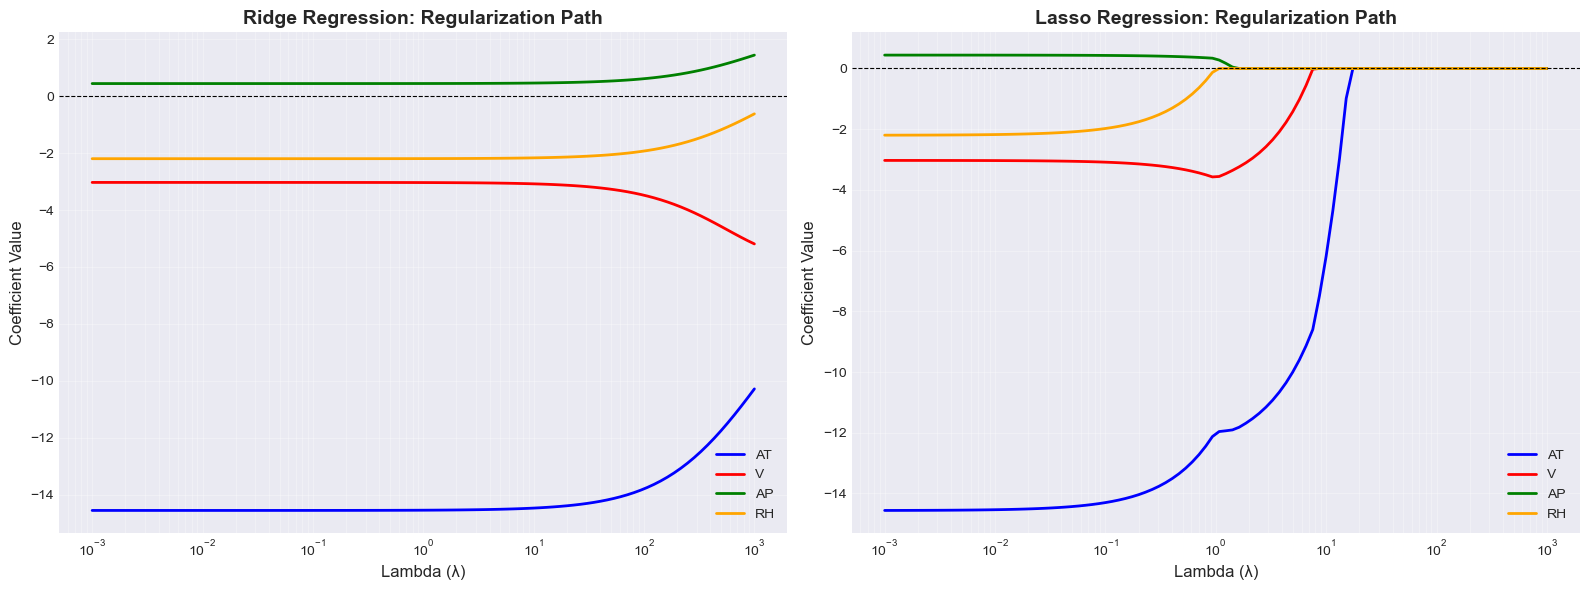

In [23]:
# Plot regularization paths
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

feature_names = ['AT', 'V', 'AP', 'RH']
colors = ['blue', 'red', 'green', 'orange']

# Plot 1: Ridge Regularization Path
for i, (feature, color) in enumerate(zip(feature_names, colors)):
    axes[0].plot(lambda_range, ridge_coeffs[:, i], label=feature, color=color, linewidth=2)

axes[0].set_xscale('log')
axes[0].set_xlabel('Lambda (λ)', fontsize=12)
axes[0].set_ylabel('Coefficient Value', fontsize=12)
axes[0].set_title('Ridge Regression: Regularization Path', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3, which='both')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Plot 2: Lasso Regularization Path
for i, (feature, color) in enumerate(zip(feature_names, colors)):
    axes[1].plot(lambda_range, lasso_coeffs[:, i], label=feature, color=color, linewidth=2)

axes[1].set_xscale('log')
axes[1].set_xlabel('Lambda (λ)', fontsize=12)
axes[1].set_ylabel('Coefficient Value', fontsize=12)
axes[1].set_title('Lasso Regression: Regularization Path', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [24]:
# Additional analysis: Show coefficient values at specific lambda points
lambda_checkpoints = [1e-3, 1e-1, 1e0, 1e1, 1e2]

print("\n" + "="*80)
print("COEFFICIENT VALUES AT SPECIFIC LAMBDA CHECKPOINTS")
print("="*80)

for lam in lambda_checkpoints:
    # Find closest lambda in our range
    idx = np.argmin(np.abs(lambda_range - lam))
    actual_lam = lambda_range[idx]
    
    print(f"\nλ ≈ {lam:.3f} (actual: {actual_lam:.4f})")
    print("-" * 60)
    
    coef_comparison = pd.DataFrame({
        'Feature': feature_names,
        'Ridge_Coef': ridge_coeffs[idx],
        'Lasso_Coef': lasso_coeffs[idx]
    })
    display(coef_comparison)
    
    # Count how many Lasso coefficients are exactly zero
    n_zeros = np.sum(np.abs(lasso_coeffs[idx]) < 1e-10)
    print(f"   Lasso: {n_zeros}/4 coefficients are zero (feature selection)")


COEFFICIENT VALUES AT SPECIFIC LAMBDA CHECKPOINTS

λ ≈ 0.001 (actual: 0.0010)
------------------------------------------------------------


,Feature,Ridge_Coef,Lasso_Coef
0,AT,-14.5566,-14.5591
1,V,-3.0307,-3.0283
2,AP,0.4425,0.4413
3,RH,-2.1971,-2.1966


   Lasso: 0/4 coefficients are zero (feature selection)

λ ≈ 0.100 (actual: 0.1000)
------------------------------------------------------------


,Feature,Ridge_Coef,Lasso_Coef
0,AT,-14.5558,-14.3007
1,V,-3.0312,-3.0858
2,AP,0.4427,0.4304
3,RH,-2.1968,-1.9769


   Lasso: 0/4 coefficients are zero (feature selection)

λ ≈ 1.000 (actual: 0.9326)
------------------------------------------------------------


,Feature,Ridge_Coef,Lasso_Coef
0,AT,-14.5489,-12.1252
1,V,-3.0354,-3.5719
2,AP,0.4443,0.3396
3,RH,-2.1944,-0.1290


   Lasso: 0/4 coefficients are zero (feature selection)

λ ≈ 10.000 (actual: 10.0000)
------------------------------------------------------------


,Feature,Ridge_Coef,Lasso_Coef
0,AT,-14.4741,-6.1837
1,V,-3.0806,-0.0000
2,AP,0.4610,0.0000
3,RH,-2.1680,0.0000


   Lasso: 3/4 coefficients are zero (feature selection)

λ ≈ 100.000 (actual: 93.2603)
------------------------------------------------------------


,Feature,Ridge_Coef,Lasso_Coef
0,AT,-13.8449,-0.0
1,V,-3.4540,-0.0
2,AP,0.6031,0.0
3,RH,-1.9447,0.0


   Lasso: 4/4 coefficients are zero (feature selection)


### Discussion: Q5 - Regularization Paths

#### 1. What happens to coefficients as λ increases in Ridge vs Lasso?

**From the plots:**

- **Ridge (left):** All four coefficients (AT, V, AP, RH) shrink **smoothly** toward zero as λ increases, but **none ever reach exactly zero**—even at large λ (e.g. 10³) they remain non-zero (e.g. AT stays around -10.5). So Ridge keeps all features.
- **Lasso (right):** Coefficients follow **piecewise linear** paths. As λ increases, **some coefficients become exactly zero**: AP (green) goes to zero first (around λ ≈ 10⁻²–10⁻¹), then AT, V, and RH go to zero at larger λ (around 10⁰–10¹). So Lasso does feature selection.
- **Small λ (e.g. ≈ 10⁻³):** Both methods give similar coefficients, close to unregularized regression (e.g. AT ≈ -14.5, V ≈ -3.5, AP ≈ 0.5, RH ≈ -2).

---

#### 2. Which regression is better under multicollinearity in IVs, and why?

**Ridge is better under multicollinearity.**

- With multicollinearity, coefficient estimates are unstable (high variance). Ridge **shrinks coefficients but keeps all features** (as in the left plot: all four curves stay non-zero), so it stabilizes estimates and spreads the effect across correlated variables.
- Lasso **sets some coefficients to zero** (right plot), so from a group of correlated IVs it picks one and zeros the others. That choice is unstable with data variation and can drop useful variables. So Ridge is preferred when IVs are correlated.

---

#### 3. Which regression is better for feature selection, and why?

**Lasso is better for feature selection.**

- In the **right plot**, Lasso sets coefficients **exactly to zero** (e.g. AP first, then AT, V, RH as λ increases), so it automatically selects which features to keep. The order they hit zero gives feature importance.
- In the **left plot**, Ridge never sets any coefficient to zero, so it **cannot** drop features. So for feature selection, Lasso is better; Ridge keeps all features.
